In [ ]:
!pip uninstall tensorflow 
!pip install tensorflow-gpu==1.14

In [ ]:
!pip uninstall keras 
!pip install keras==2.2.4

In [ ]:
pip install h5py==2.10.0 --force-reinstall #need to install h5 ,otherwise it won't load the model properly

In [ ]:
#!pip install h5py==2.10.0 --force-reinstall #need to install h5 ,otherwise it won't load the model properly

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!cp /content/gdrive/MyDrive/Flood_Project/Image_Stylization/instancenormalization.py /content

In [ ]:
from instancenormalization import InstanceNormalization  
from keras.models import load_model
from matplotlib import pyplot
from numpy.random import randint
from os import listdir
from numpy import asarray
from numpy import vstack
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from matplotlib import pyplot as plt
import numpy as np
import h5py
from matplotlib.pyplot import figure

In [ ]:
# load all images in a directory into memory
def load_images(path, size=(256,256)):
	data_list = list()
	# enumerate filenames in directory, assume all are images
	for filename in listdir(path):
		# load and resize the image
		pixels = load_img(path + filename, target_size=size)
		# convert to numpy array
		pixels = img_to_array(pixels)
		# store
		data_list.append(pixels)
	return asarray(data_list)

In [ ]:
# dataset path
path = '/content/gdrive/MyDrive/Flood_Project/Image_Stylization/Synthetic_to_Real/'

In [ ]:
# load dataset A - Real Images
dataA_all = load_images(path + 'testA/')
print('Loaded dataA: ', dataA_all.shape)

from sklearn.utils import resample
#To get a subset of all images, for faster training during demonstration
dataA = resample(dataA_all, 
                 replace=False,     
                 n_samples=100,    
                 random_state=42) 

# load dataset B - Synhetic Images
dataB_all = load_images(path + 'testB/')
print('Loaded dataB: ', dataB_all.shape)
#Get a subset of all images, for faster training during demonstration
#We could have just read the list of files and only load a subset, better memory management. 
dataB = resample(dataB_all, 
                 replace=False,     
                 n_samples=100,    
                 random_state=42) 

Loaded dataA:  (259, 256, 256, 3)
Loaded dataB:  (482, 256, 256, 3)


In [ ]:
# select a random sample of images from the dataset
def select_sample(dataset, n_samples):
	# choose random instances
	ix = randint(0, dataset.shape[0], n_samples)
	# retrieve selected images
	X = dataset[ix]
	return X

In [ ]:
# plot the image, its translation, and the reconstruction
def show_plot(imagesX, imagesY1, imagesY2):
	images = vstack((imagesX, imagesY1, imagesY2))
	titles = ['Original (Synthetic)', 'Model Translated (Syn>Real)', 'Model Reconstructed(back to Synthetic)']
	# scale from [-1,1] to [0,1]
	images = (images + 1) / 2.0
	# plot images row by row
	for i in range(len(images)):
		figure(figsize=(20, 15), dpi=80)
		# define subplot
		pyplot.subplot(1, len(images) ,1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(images[i])
		# title
		pyplot.title(titles[i])
	pyplot.show()

In [ ]:
# load dataset
A_data = resample(dataA_all, 
                 replace=False,     
                 n_samples=50,    
                 random_state=42) # reproducible results

B_data = resample(dataB_all, 
                 replace=False,     
                 n_samples=50,    
                 random_state=42) # reproducible results

A_data = (A_data - 127.5) / 127.5
B_data = (B_data - 127.5) / 127.5

In [ ]:
# load the models
cust = {'InstanceNormalization': InstanceNormalization}
model_BtoA = load_model('/content/gdrive/MyDrive/Flood_Project/Image_Stylization/log_3/gen_ba_v2_7800.h5', cust)
model_AtoB = load_model('/content/gdrive/MyDrive/Flood_Project/Image_Stylization/log_3/gen_ab_v2_7800.h5', cust)

/usr/local/lib/python3.7/dist-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


(1, 256, 256, 3)


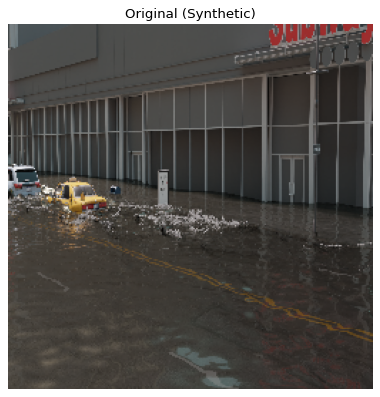

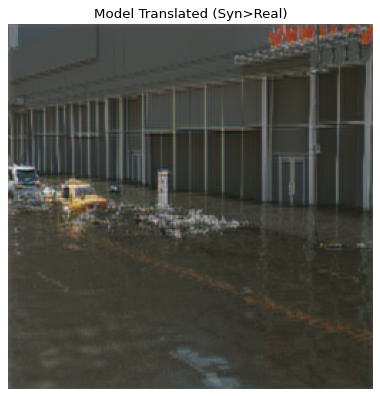

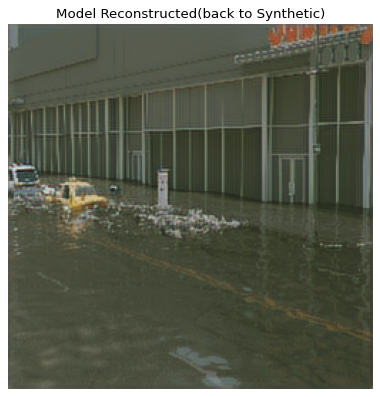

In [ ]:
# plot B->A->B (Synthetic to Real to Synthetic)
B_real = select_sample(B_data, 1)
print(B_real.shape)
A_generated  = model_BtoA.predict(B_real)
B_reconstructed = model_AtoB.predict(A_generated)
show_plot(B_real, A_generated, B_reconstructed)

In [ ]:
# plot A->B->A (Real to Synthetic to Real)
A_real = select_sample(A_data, 1)
B_generated  = model_AtoB.predict(A_real)
A_reconstructed = model_BtoA.predict(B_generated)
show_plot(A_real, B_generated, A_reconstructed)

#Saving generated image in a folder########

In [ ]:
#test_img_path="/content/gdrive/MyDrive/Flood_Project/Image_Stylization/test/" #synthetic test image path
#out_path="/content/gdrive/MyDrive/Flood_Project/Image_Stylization/test_output" #generated synthetic>real

In [ ]:
test_img_path="/content/gdrive/MyDrive/Flood_Project/Synthetic_Flood_Images_Blender/2048_Synthetic_Blender_Image_256_256/" #synthetic test image path
out_path="/content/gdrive/MyDrive/Flood_Project/Synthetic_Flood_Images_Blender/2048_Translated_Image_CylceGAN_VGG" #generated synthetic>real

In [ ]:
import os
from PIL import Image 
import cv2
import numpy
size=(256,256)
for file in os.listdir(test_img_path):
  print(file)
  filename=file.split('.')[0]
  pixels=load_img(test_img_path+ file, target_size=size)
  img_arr= img_to_array(pixels)
  img_arr=np.expand_dims(img_arr,axis=0)
  #print(img_arr.shape)
  generated_img  = model_BtoA.predict(img_arr) #synthectic to real translation
  #generated_img  = (generated_img + 1) / 2.0
  generated_img= np.array(generated_img)
  #print(generated_img.shape)
  out_img=np.squeeze(generated_img,axis=0)
  fn=f'{out_path}/{filename}.png'
  result = Image.fromarray((out_img * 255).astype(numpy.uint8))
  result.save(fn)
  #plt.savefig(out_path+filename+'.png') 
  print(fn)
  #fn=f'{out_path}/{filename}.png'
  #cv2.imwrite(fn,out_img)

0776000.png
/content/gdrive/MyDrive/Flood_Project/Synthetic_Flood_Images_Blender/2048_Translated_Image_CylceGAN_VGG/0776000.png
0776006.png
/content/gdrive/MyDrive/Flood_Project/Synthetic_Flood_Images_Blender/2048_Translated_Image_CylceGAN_VGG/0776006.png
0775005.png
/content/gdrive/MyDrive/Flood_Project/Synthetic_Flood_Images_Blender/2048_Translated_Image_CylceGAN_VGG/0775005.png
0775006.png
/content/gdrive/MyDrive/Flood_Project/Synthetic_Flood_Images_Blender/2048_Translated_Image_CylceGAN_VGG/0775006.png
0776001.png
/content/gdrive/MyDrive/Flood_Project/Synthetic_Flood_Images_Blender/2048_Translated_Image_CylceGAN_VGG/0776001.png
0776004.png
/content/gdrive/MyDrive/Flood_Project/Synthetic_Flood_Images_Blender/2048_Translated_Image_CylceGAN_VGG/0776004.png
0775007.png
/content/gdrive/MyDrive/Flood_Project/Synthetic_Flood_Images_Blender/2048_Translated_Image_CylceGAN_VGG/0775007.png
0777005.png
/content/gdrive/MyDrive/Flood_Project/Synthetic_Flood_Images_Blender/2048_Translated_Image_C

#Sampling Images from One folder to another folder######## 

In [5]:


import os
import random
import shutil


files_list = []

for root, dirs, files in os.walk("/content/gdrive/MyDrive/Flood_Project/Synthetic_Flood_Images_Blender/translated_train_val_test_2/val/image"):
    for file in files:
        #all 
        if file.endswith(".jpg") or file.endswith(".png") or file.endswith(".jpeg"):
            files_list.append(os.path.join(root, file))


#print images
#lets me count and print the amount of jpeg,jpg,pmg 
file_count = len(files_list)
print (file_count)

# print files_list   
filesToCopy = random.sample(files_list, 164)  #prints 200 random files from list 

destPath = "/content/gdrive/MyDrive/Flood_Project/Synthetic_Flood_Images_Blender/translated_train_val_test_2/val/image_164"

# if destination dir does not exists, create it
if os.path.isdir(destPath) == False:
        os.makedirs(destPath)

# iteraate over all random files and copy them
for file in filesToCopy:
    shutil.copy(file, destPath)

440


#FID score calculation of Images

In [ ]:
from PIL import Image
import os

synthetic_img_path="/content/gdrive/MyDrive/Flood_Project/Image_Stylization/Synthetic_to_Real/testB_200_Output_CycleGAN_VGG"
real_img_path="/content/gdrive/MyDrive/Flood_Project/Image_Stylization/Synthetic_to_Real/testA_200"

In [ ]:
synthetic_images=[]
real_images=[]

for img in os.listdir(synthetic_img_path):
  image=Image.open(os.path.join(synthetic_img_path,img))
  synthetic_images.append(image)

for img in os.listdir(real_img_path):
  image=Image.open(os.path.join(real_img_path,img))
  real_images.append(image)


In [ ]:
# convert integer to floating point values
#images1 = np.asarray(synthetic_images, dtype="float32")
#images2 = np.asarray(real_images, dtype="float32")
images1=[]
for img in synthetic_images:
  image=np.asarray(img, dtype="float32")
  images1.append(image)

In [ ]:
images2=[]
for img in real_images:
  image=np.asarray(img, dtype="float32")
  images2.append(image)

In [ ]:
# example of calculating the frechet inception distance in Keras
import numpy
from numpy import cov
from numpy import trace
from numpy import iscomplexobj
from numpy import asarray
from numpy.random import randint
from scipy.linalg import sqrtm
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from skimage.transform import resize

In [ ]:
# scale an array of images to a new size
def scale_images(images, new_shape):
	images_list = list()
	for image in images:
		# resize with nearest neighbor interpolation
		new_image = resize(image, new_shape, 0)
		# store
		images_list.append(new_image)
	return asarray(images_list)
 
# calculate frechet inception distance
def calculate_fid(model, images1, images2):
	# calculate activations
	act1 = model.predict(images1)
	act2 = model.predict(images2)
	# calculate mean and covariance statistics
	mu1, sigma1 = act1.mean(axis=0), cov(act1, rowvar=False)
	mu2, sigma2 = act2.mean(axis=0), cov(act2, rowvar=False)
	# calculate sum squared difference between means
	ssdiff = numpy.sum((mu1 - mu2)**2.0)
	# calculate sqrt of product between cov
	covmean = sqrtm(sigma1.dot(sigma2))
	# check and correct imaginary numbers from sqrt
	if iscomplexobj(covmean):
		covmean = covmean.real
	# calculate score
	fid = ssdiff + trace(sigma1 + sigma2 - 2.0 * covmean)
	return fid
 
# prepare the inception v3 model
model = InceptionV3(include_top=False, pooling='avg', input_shape=(299,299,3))

In [ ]:
# resize images
images1 = scale_images(images1, (299,299,3))
images2 = scale_images(images2, (299,299,3))
print('Scaled', images1.shape, images2.shape)

Scaled (200, 299, 299, 3) (200, 299, 299, 3)


In [ ]:
# pre-process images
images1 = preprocess_input(images1)
images2 = preprocess_input(images2)

In [ ]:
# fid between images1 and images2
fid = calculate_fid(model, images1, images2)
print('FID (different): %.3f' % fid)

FID (different): 212.609


#Resize Images and Save in Another Folder

In [ ]:
from PIL import Image
import glob
import os

# new folder path (may need to alter for Windows OS)
# change path to your path
path = '/content/gdrive/MyDrive/Flood_Project/Real Images_and_mask/Real_Immage_and_mask_three_level/Sazara/car_image_256_256' #the path where to save resized images
# create new folder
if not os.path.exists(path):
    os.makedirs(path)

# loop over existing images and resize
# change path to your path
for filename in glob.glob('/content/gdrive/MyDrive/Flood_Project/Real Images_and_mask/Real_Immage_and_mask_three_level/Sazara/car_image/*.png'): #path of raw images
    img = Image.open(filename).resize((256,256))
    # save resized images to new folder with existing filename
    img.save('{}{}{}'.format(path,'/',os.path.split(filename)[1]))